
# covariates_builder_9923.ipynb

A readable notebook version of the NHANES **1999–2023 Covariates Builder**.

**What this builds (to your `Config.out_dir`):**
- `cov_smk_1999_2023.parquet`
- `cov_alc_1999_2023.parquet`
- `cov_pa_1999_2023.parquet`
- `cov_bmx_1999_2023.parquet`
- `cov_clinical_1999_2023.parquet`
- `cov_household_1999_2023.parquet`
- `cov_core_1999_2023.parquet`

Tip: keep this notebook for reading, and call the functions from your thin `02_build_covariates.ipynb`.


## Setup

In [1]:

from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
from typing import Dict, Optional

import numpy as np
import pandas as pd

# Display options (optional)
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)


## Configuration

In [2]:

# Base project folder (adjust if needed)
BASE = Path("/Users/dengshuyue/Desktop/SDOH/analysis")

@dataclass
class Config:
    # Where inputs/outputs live
    raw_dir: Path = BASE / "data"
    interim_dir: Path = BASE / "data" / "cov"
    out_dir: Path = BASE / "output"

    # Preferred inputs
    demo_9923: Path = BASE / "data" / "cov" / "demo9923.parquet"
    demo_9918: Optional[Path] = None

    bmx_9923: Optional[Path] = None

    smk_9918: Optional[Path] = None
    smk_1923: Optional[Path] = None

    pa_9918_imputed: Optional[Path] = None
    pa_1923: Optional[Path] = None

    clinical_9918: Optional[Path] = None
    clinical_1923: Optional[Path] = None

    # Output file names
    cov_smk: str = "cov_smk_1999_2023.parquet"
    cov_alc: str = "cov_alc_1999_2023.parquet"
    cov_pa: str = "cov_pa_1999_2023.parquet"
    cov_bmx: str = "cov_bmx_1999_2023.parquet"
    cov_clinical: str = "cov_clinical_1999_2023.parquet"
    cov_household: str = "cov_household_1999_2023.parquet"
    cov_core: str = "cov_core_1999_2023.parquet"

CONFIG = Config()


## Utilities

In [3]:

NHANES_MISS = {7, 9, 77, 99, 777, 999, 7777, 9999, 77777, 99999}

def log(msg: str) -> None:
    print(msg, flush=True)

def ensure_dir(p: Path) -> None:
    p.mkdir(parents=True, exist_ok=True)

def upper_df(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    d.columns = [c.upper() for c in d.columns]
    return d

def nhanes_na(s: pd.Series) -> pd.Series:
    return pd.to_numeric(s, errors="coerce").mask(lambda x: x.isin(NHANES_MISS))

def read_any(p: Path) -> pd.DataFrame:
    return pd.read_parquet(p) if p.suffix == ".parquet" else pd.read_csv(p, low_memory=False)

def pick_first_existing(*candidates: Optional[Path]) -> Optional[Path]:
    for c in candidates:
        if c and Path(c).exists():
            return Path(c)
    return None


## Smoking (SMQ)

In [13]:
SMK_STATUS_CATS = pd.CategoricalDtype(["NEVER", "FORMER", "CURRENT"], ordered=True)

def build_smk(cfg: Config = CONFIG) -> pd.DataFrame:
    """
    Build smoking covariates with tolerant inputs.

    Accepts either a pre-standardized stack (columns already include:
      SEQN, SMK_STATUS, CIGS_PER_DAY, PACK_YEARS, FORMER_SMOKER)
    OR derives those columns from common legacy/raw fields:
      - SMK (1=NEVER, 2=FORMER, 3=CURRENT)
      - SMK_AVG (cigs/day)
      - PACK_YR (pack-years)
      - SMK_YR (years smoked)
      - Optionally SMQ020/SMQ040/SMQ050Q/SMQ050U/SMD030 if present
    """
    ensure_dir(cfg.out_dir)

    def _read_any(p: Path) -> pd.DataFrame:
        return pd.read_parquet(p) if str(p).endswith(".parquet") else pd.read_csv(p, low_memory=False)

    # 1) Locate sources (prefer combined 99–23; else 99–18 (+ optional 19–23))
    smk_9923 = pick_first_existing(
        cfg.interim_dir / "smk_9923.parquet",
        cfg.interim_dir / "smk_9923.csv",
    )
    if smk_9923:
        smk = upper_df(_read_any(smk_9923))
        src_msg = f"using {smk_9923.name}"
    else:
        p9918 = pick_first_existing(cfg.smk_9918, cfg.interim_dir / "smk_9918.parquet", cfg.interim_dir / "smk_9918.csv")
        p1923 = pick_first_existing(cfg.smk_1923, cfg.interim_dir / "smk_1923.parquet", cfg.interim_dir / "smk_1923.csv")
        if p9918 is None:
            raise FileNotFoundError("Provide smk_9923 or smk_9918 (csv/parquet) under interim.")
        smk = upper_df(_read_any(p9918))
        if p1923:
            smk = pd.concat([smk, upper_df(_read_any(p1923))], ignore_index=True)
            src_msg = f"using {Path(p9918).name} + {Path(p1923).name}"
        else:
            src_msg = f"using {Path(p9918).name}"

    # 2) If standardized columns already exist, just use them
    needed = {"SEQN", "SMK_STATUS", "CIGS_PER_DAY", "PACK_YEARS", "FORMER_SMOKER"}
    have_std = needed.issubset(set(smk.columns))

    if not have_std:
        # 3) Derive standardized columns from legacy/raw fields
        d = smk.copy()

        # Drop obvious junk index cols if present
        for junk in ["UNNAMED: 0", "INDEX"]:
            if junk in d.columns:
                d = d.drop(columns=[junk])

        out = pd.DataFrame({"SEQN": d["SEQN"]})

        # --- SMK_STATUS ---
        # Priority 1: direct SMK_STATUS if it exists but wasn’t part of 'needed'
        if "SMK_STATUS" in d.columns:
            smk_status = d["SMK_STATUS"].astype("string").str.strip().str.upper()
        else:
            # Priority 2: numeric SMK (1=NEVER,2=FORMER,3=CURRENT)
            smk_num = pd.to_numeric(d.get("SMK"), errors="coerce")
            smk_status = smk_num.map({1: "NEVER", 2: "FORMER", 3: "CURRENT"}).astype("string")

            # Priority 3: derive from SMQ020/SMQ040 if available
            if smk_status.isna().all() and (("SMQ020" in d.columns) or ("SMQ040" in d.columns)):
                ever = d.get("SMQ020")  # 1=Yes (ever 100 cigs), 2=No
                if ever is not None:
                    ever = pd.to_numeric(ever, errors="coerce").replace({2: 0, 1: 1})
                smq040 = pd.to_numeric(d.get("SMQ040"), errors="coerce")  # 1=Every day,2=Some days,3=Not at all

                # default NEVER; flip to FORMER/CURRENT based on ever/smq040
                smk_status = pd.Series("NEVER", index=d.index, dtype="string")
                if ever is not None:
                    smk_status = smk_status.mask(ever == 1, "FORMER")
                if smq040 is not None:
                    smk_status = smk_status.mask(smq040.isin([1, 2]), "CURRENT")
                    smk_status = smk_status.mask(smq040 == 3, "FORMER")

        out["SMK_STATUS"] = smk_status.astype("string").str.upper()

        # --- CIGS_PER_DAY ---
        cigs = pd.to_numeric(d.get("SMK_AVG"), errors="coerce")  # your legacy field
        if cigs.isna().all():
            # try SMQ050Q/U (quantity + unit 1=day,2=week,3=month)
            q = pd.to_numeric(d.get("SMQ050Q"), errors="coerce")
            u = pd.to_numeric(d.get("SMQ050U"), errors="coerce")
            if q is not None and u is not None:
                cigs = (
                    q.where(u == 1)
                    .fillna((q / 7.0).where(u == 2))
                    .fillna((q / 30.0).where(u == 3))
                )
        out["CIGS_PER_DAY"] = cigs

        # --- PACK_YEARS ---
        pack_years = pd.to_numeric(d.get("PACK_YR"), errors="coerce")
        if pack_years.isna().all():
            years = pd.to_numeric(d.get("SMK_YR"), errors="coerce")
            if years is None or years.isna().all():
                years = pd.to_numeric(d.get("SMD030"), errors="coerce")  # years smoked in some SMQ cycles
            pack_years = (out["CIGS_PER_DAY"] / 20.0) * years
        out["PACK_YEARS"] = pack_years

        # --- FORMER_SMOKER ---
        out["FORMER_SMOKER"] = out["SMK_STATUS"].eq("FORMER").fillna(False).astype("int8")

        # Clean up obviously invalid values
        out.loc[out["CIGS_PER_DAY"] < 0, "CIGS_PER_DAY"] = np.nan
        out.loc[out["PACK_YEARS"] < 0, "PACK_YEARS"] = np.nan

        smk_std = out

    else:
        # Already standardized
        smk_std = smk[list(needed)].copy()
        smk_std["SMK_STATUS"] = smk_std["SMK_STATUS"].astype("string").str.upper()
        smk_std["FORMER_SMOKER"] = pd.to_numeric(smk_std["FORMER_SMOKER"], errors="coerce").fillna(0).astype("int8")

    # 4) Final tidy + write
    smk_std = smk_std.drop_duplicates("SEQN")
    smk_std["SMK_STATUS"] = smk_std["SMK_STATUS"].astype("category").cat.set_categories(SMK_STATUS_CATS.categories, ordered=True)
    outp = cfg.out_dir / cfg.cov_smk
    smk_std.to_parquet(outp, index=False)

    # Light telemetry
    miss_rate = smk_std[["SMK_STATUS", "CIGS_PER_DAY", "PACK_YEARS"]].isna().mean().round(3).to_dict()
    log(f"✓ SMK → {outp} ({src_msg}); missing: {miss_rate}")

    return smk_std


## Alcohol (ALQ) 99-23

In [29]:
# ---------- Alcohol builder with optional CDC fetch (revised) ----------
import pandas as pd, numpy as np
from pathlib import Path

# --- tiny local helpers (safe fallbacks if your notebook didn't define them) ---
def upper_df(df: pd.DataFrame) -> pd.DataFrame:
    df.columns = [c.upper() for c in df.columns]
    return df

def ensure_dir(p: Path | str):
    Path(p).mkdir(parents=True, exist_ok=True)

def pick_first_existing(*paths):
    for p in paths:
        if p and Path(p).exists():
            return Path(p)
    return None

def log(msg: str):  # nice-to-have
    print(msg)

# --- IO helpers ---
def _read_any(p: Path) -> pd.DataFrame:
    p = Path(p)
    if p.suffix.lower() == ".parquet":
        return pd.read_parquet(p)
    return pd.read_csv(p, low_memory=False)

def _clean_num(s: pd.Series) -> pd.Series:
    NH_MISS = {7, 9, 77, 99, 777, 999, 7777, 9999, 77777, 99999}
    s = pd.to_numeric(s, errors="coerce")
    return s.mask(s.isin(NH_MISS))

def _download(url: str, dest: Path, timeout=90):
    import requests
    dest.parent.mkdir(parents=True, exist_ok=True)
    headers = {"User-Agent": "nhanes-fetch/1.0"}
    with requests.get(url, headers=headers, stream=True, timeout=timeout) as r:
        r.raise_for_status()
        tmp = dest.with_suffix(dest.suffix + ".downloading")
        with open(tmp, "wb") as f:
            for chunk in r.iter_content(1 << 15):
                if chunk:
                    f.write(chunk)
        tmp.rename(dest)
    return dest

def _read_xpt(p: Path) -> pd.DataFrame:
    try:
        import pyreadstat
        df, _ = pyreadstat.read_xport(p)
    except Exception:
        df = pd.read_sas(p, format="xport")
    df.columns = [c.upper() for c in df.columns]
    return df

# --- minimal DEMO sex loader (RIAGENDR) ---
def _ensure_demo_sex(cfg) -> pd.DataFrame:
    """Return DEMO with SEQN, RIAGENDR. Try configured paths; else build minimal by fetching."""
    # 1) Try configured demo
    demo_path = None
    for cand in [
        getattr(cfg, "demo_9923", None),
        getattr(cfg, "demo_9918", None),
        cfg.interim_dir / "demo_9923.parquet",
        cfg.interim_dir / "demo_9918.parquet",
    ]:
        if cand and Path(cand).exists():
            demo_path = Path(cand)
            break
    if demo_path:
        demo = _read_any(demo_path)
        demo = upper_df(demo)
        if "RIAGENDR" in demo.columns:
            return demo[["SEQN", "RIAGENDR"]].drop_duplicates("SEQN")

    # 2) Build minimal by fetching RIAGENDR across cycles
    DEMO_URLS = {
        "1999-2000": [
            "https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/1999/DataFiles/DEMO.xpt",
            "https://wwwn.cdc.gov/Nchs/Nhanes/1999-2000/DEMO.XPT",
        ],
        "2001-2002": [
            "https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2001/DataFiles/DEMO_B.xpt",
            "https://wwwn.cdc.gov/Nchs/Nhanes/2001-2002/DEMO_B.XPT",
        ],
        "2003-2004": [
            "https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2003/DataFiles/DEMO_C.xpt",
            "https://wwwn.cdc.gov/Nchs/Nhanes/2003-2004/DEMO_C.XPT",
        ],
        "2005-2006": [
            "https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2005/DataFiles/DEMO_D.xpt",
            "https://wwwn.cdc.gov/Nchs/Nhanes/2005-2006/DEMO_D.XPT",
        ],
        "2007-2008": [
            "https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2007/DataFiles/DEMO_E.xpt",
            "https://wwwn.cdc.gov/Nchs/Nhanes/2007-2008/DEMO_E.XPT",
        ],
        "2009-2010": [
            "https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2009/DataFiles/DEMO_F.xpt",
            "https://wwwn.cdc.gov/Nchs/Nhanes/2009-2010/DEMO_F.XPT",
        ],
        "2011-2012": [
            "https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2011/DataFiles/DEMO_G.xpt",
            "https://wwwn.cdc.gov/Nchs/Nhanes/2011-2012/DEMO_G.XPT",
        ],
        "2013-2014": [
            "https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2013/DataFiles/DEMO_H.xpt",
            "https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/DEMO_H.XPT",
        ],
        "2015-2016": [
            "https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2015/DataFiles/DEMO_I.xpt",
            "https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DEMO_I.XPT",
        ],
        "2017-2018": [
            "https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/DEMO_J.xpt",
            "https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/DEMO_J.XPT",
        ],
        "2017-March 2020 (pre-pandemic)": [
            "https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/P_DEMO.xpt",
            "https://wwwn.cdc.gov/Nchs/Nhanes/2017-2020/P_DEMO.XPT",
        ],
        "August 2021–August 2023": [
            "https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/DEMO_L.xpt",
            "https://wwwn.cdc.gov/Nchs/Nhanes/2021-2023/DEMO_L.XPT",
        ],
    }
    store = Path(cfg.interim_dir)
    parts = []
    for cyc, urls in DEMO_URLS.items():
        got = None
        for u in urls:
            try:
                dst = store / Path(u).name
                if not dst.exists():
                    print(f"⬇️ DEMO {cyc} → {dst.name}")
                    _download(u, dst)
                got = dst
                break
            except Exception as e:
                print("  ⚠️", e)
        if got is None:
            continue
        df = _read_xpt(got)
        if {"SEQN", "RIAGENDR"}.issubset(df.columns):
            parts.append(df[["SEQN", "RIAGENDR"]])
    if not parts:
        raise RuntimeError("Could not build minimal DEMO (RIAGENDR).")
    demo = pd.concat(parts, ignore_index=True).drop_duplicates("SEQN")
    out_demo = store / "demo_riagendr_min.parquet"
    demo.to_parquet(out_demo, index=False)
    return demo

# --- ALQ downloader/stacker ---
def _download_and_stack_alq(cfg) -> pd.DataFrame:
    """Download ALQ XPTs to interim/alcohol/, stack minimal columns used for dpd."""
    ALC_STORE = Path(cfg.interim_dir) / "alcohol"
    ALC_STORE.mkdir(parents=True, exist_ok=True)
    ALQ_URLS = {
        "1999-2000": [
            "https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/1999/DataFiles/ALQ.xpt",
            "https://wwwn.cdc.gov/Nchs/Nhanes/1999-2000/ALQ.XPT",
        ],
        "2001-2002": [
            "https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2001/DataFiles/ALQ_B.xpt",
            "https://wwwn.cdc.gov/Nchs/Nhanes/2001-2002/ALQ_B.XPT",
        ],
        "2003-2004": [
            "https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2003/DataFiles/ALQ_C.xpt",
            "https://wwwn.cdc.gov/Nchs/Nhanes/2003-2004/ALQ_C.XPT",
        ],
        "2005-2006": [
            "https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2005/DataFiles/ALQ_D.xpt",
            "https://wwwn.cdc.gov/Nchs/Nhanes/2005-2006/ALQ_D.XPT",
        ],
        "2007-2008": [
            "https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2007/DataFiles/ALQ_E.xpt",
            "https://wwwn.cdc.gov/Nchs/Nhanes/2007-2008/ALQ_E.XPT",
        ],
        "2009-2010": [
            "https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2009/DataFiles/ALQ_F.xpt",
            "https://wwwn.cdc.gov/Nchs/Nhanes/2009-2010/ALQ_F.XPT",
        ],
        "2011-2012": [
            "https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2011/DataFiles/ALQ_G.xpt",
            "https://wwwn.cdc.gov/Nchs/Nhanes/2011-2012/ALQ_G.XPT",
        ],
        "2013-2014": [
            "https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2013/DataFiles/ALQ_H.xpt",
            "https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/ALQ_H.XPT",
        ],
        "2015-2016": [
            "https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2015/DataFiles/ALQ_I.xpt",
            "https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/ALQ_I.XPT",
        ],
        "2017-2018": [
            "https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/ALQ_J.xpt",
            "https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/ALQ_J.XPT",
        ],
        "2017-March 2020 (pre-pandemic)": [
            "https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/P_ALQ.xpt",
            "https://wwwn.cdc.gov/Nchs/Nhanes/2017-2020/P_ALQ.XPT",
        ],
        "August 2021–August 2023": [
            "https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/ALQ_L.xpt",
            "https://wwwn.cdc.gov/Nchs/Nhanes/2021-2023/ALQ_L.XPT",
            "https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/ALQ_Q.xpt",
            "https://wwwn.cdc.gov/Nchs/Nhanes/2021-2023/ALQ_Q.XPT",
        ],
    }
    parts = []
    for cycle, urls in ALQ_URLS.items():
        got = None
        for u in urls:
            try:
                dst = ALC_STORE / Path(u).name
                if not dst.exists():
                    print(f"⬇️ ALQ {cycle} → {dst.name}")
                    _download(u, dst)
                got = dst
                break
            except Exception as e:
                print("  ⚠️", e)
        if got is None:
            continue
        df = _read_xpt(got)
        df["CYCLE"] = cycle
        keep = [c for c in ["SEQN", "CYCLE", "ALQ110", "ALQ151", "ALQ120Q", "ALQ120U", "ALQ130"] if c in df.columns]
        parts.append(df[keep])
    if not parts:
        raise RuntimeError("No ALQ data available (download failed).")
    alq = pd.concat(parts, ignore_index=True)
    # Persist stacked ALQ for reuse
    stacked = Path(cfg.interim_dir) / "alq_9923.parquet"
    stacked.parent.mkdir(parents=True, exist_ok=True)
    alq.to_parquet(stacked, index=False)
    return alq

# --- derive drinks/day ---
def _drinks_per_day_from_alq(alq: pd.DataFrame) -> pd.Series:
    d = upper_df(alq)
    count = _clean_num(d.get("ALQ120Q", pd.Series(np.nan, index=d.index)))
    unit  = d.get("ALQ120U", pd.Series(np.nan, index=d.index))
    per_year = pd.Series(np.nan, index=d.index, dtype="float")
    per_year = per_year.where(~(unit == 1), 365.0)
    per_year = per_year.where(~(unit == 2), 52.142)
    per_year = per_year.where(~(unit == 3), 12.0)
    per_year = per_year.where(~(unit == 4), 1.0)
    occasions_per_year = count * per_year

    drinks_per_occasion = _clean_num(d.get("ALQ130", pd.Series(np.nan, index=d.index)))
    dpd = (occasions_per_year * drinks_per_occasion) / 365.0
    return dpd.where(occasions_per_year.notna() & drinks_per_occasion.notna())

# --- categorize with explicit index alignment (fixes FutureWarning) ---
def _categorize_alcohol(dpd: pd.Series, sex: pd.Series, lifetime_lt12: pd.Series | None) -> pd.Series:
    # Normalize inputs and drop index labels to ensure 1:1 positional alignment
    dpd  = pd.to_numeric(dpd, errors="coerce").reset_index(drop=True)
    sexM = pd.to_numeric(sex, errors="coerce").map({1: "M", 2: "F"}).astype("string").reset_index(drop=True)
    if lifetime_lt12 is None:
        life = pd.Series(pd.NA, index=dpd.index)
    else:
        life = pd.to_numeric(lifetime_lt12, errors="coerce").reset_index(drop=True)

    # Masks (now same RangeIndex → no alignment warning)
    none_mask     = dpd.isna() | (dpd < 0.03) | (life == 1)               # <12 lifetime OR <0.03/day
    heavy_mask    = ((sexM == "F") & (dpd >= 1.0)) | ((sexM == "M") & (dpd >= 2.0))
    moderate_mask = (~none_mask) & (~heavy_mask)

    cat = pd.Series("NONE", index=dpd.index, dtype="string")
    cat.loc[moderate_mask] = "MODERATE"
    cat.loc[heavy_mask]    = "HEAVY"
    return pd.Categorical(cat, categories=["NONE", "MODERATE", "HEAVY"], ordered=True)

# --- public builder ---
def build_alc(cfg: "Config" = CONFIG, allow_fetch: bool = True) -> pd.DataFrame:
    """
    Build alcohol covariates.
      • Prefer existing output in cfg.out_dir
      • Else prefer stacked ALQ in cfg.interim_dir
      • Else, if allow_fetch: download ALQ XPTs and stack
    Writes {cfg.out_dir}/{cfg.cov_alc}
    """
    ensure_dir(cfg.out_dir)

    # A) If already built, return it
    out_path = Path(cfg.out_dir) / cfg.cov_alc
    if out_path.exists():
        return pd.read_parquet(out_path)

    # B) Load ALQ stack (prefer 99–23, else 99–18). If missing and allowed, fetch.
    alq_path = pick_first_existing(
        Path(cfg.interim_dir) / "alq_9923.parquet",
        Path(cfg.interim_dir) / "alq_9918.parquet",
    )
    if alq_path:
        alq = _read_any(alq_path)
    else:
        if not allow_fetch:
            raise FileNotFoundError(
                "ALQ stack not found (alq_9923 / alq_9918). Set allow_fetch=True to download from CDC."
            )
        alq = _download_and_stack_alq(cfg)

    alq = upper_df(alq)
    dpd = _drinks_per_day_from_alq(alq)

    # lifetime <12 drinks indicator
    life = None
    if "ALQ110" in alq.columns:
        life = (pd.to_numeric(alq["ALQ110"], errors="coerce") == 2).astype("Int8")
    elif "ALQ151" in alq.columns:
        life = (pd.to_numeric(alq["ALQ151"], errors="coerce") == 2).astype("Int8")

    # Bring in sex (1=male, 2=female) aligned to ALQ rows
    demo = _ensure_demo_sex(cfg)
    demo = upper_df(demo).drop_duplicates("SEQN")
    sex = demo.set_index("SEQN").reindex(alq["SEQN"])["RIAGENDR"]

    # Categorize with aligned masks
    alc_cat = _categorize_alcohol(dpd, sex=sex, lifetime_lt12=life)

    out = pd.DataFrame(
        {
            "SEQN": alq["SEQN"].reset_index(drop=True),
            "DRINKS_PER_DAY": pd.to_numeric(dpd, errors="coerce").reset_index(drop=True),
            "ALCOHOL_CAT": alc_cat,
        }
    )
    out.to_parquet(out_path, index=False)
    log(f"✓ ALC → {out_path}")
    return out
# ---------- end alcohol builder (revised) ----------


## Physical Activity (PA) 99-23

#### check one cycle PA first 

In [101]:
from pathlib import Path
import pandas as pd

# Choose a cycle to inspect
cycle = "2011-2012"
urls = [
    # PAQ_G
    "https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2011/DataFiles/PAQ_G.xpt",
    "https://wwwn.cdc.gov/Nchs/Nhanes/2011-2012/PAQ_G.XPT",
]

interim = Path("/Users/dengshuyue/Desktop/SDOH/analysis/interim/pa")
interim.mkdir(parents=True, exist_ok=True)

def _download(url, dest):
    import requests
    if dest.exists(): 
        return dest
    with requests.get(url, headers={"User-Agent":"nhanes-pa/1.0"}, stream=True, timeout=90) as r:
        r.raise_for_status()
        tmp = dest.with_suffix(dest.suffix + ".downloading")
        with open(tmp, "wb") as f:
            for chunk in r.iter_content(1<<15):
                if chunk: f.write(chunk)
        tmp.rename(dest)
    return dest

# Try the two official links
xpt_path = None
for u in urls:
    try:
        cand = interim / Path(u).name
        xpt_path = _download(u, cand)
        break
    except Exception as e:
        print("⚠️", e)

if xpt_path is None:
    raise RuntimeError("Could not fetch PAQ for the chosen cycle.")

# Read XPT (either pyreadstat or pandas works)
try:
    import pyreadstat
    df, _ = pyreadstat.read_xport(xpt_path)
except Exception:
    df = pd.read_sas(xpt_path, format="xport")

df.columns = [c.upper() for c in df.columns]
print("Cycle:", cycle, "| shape:", df.shape)
print("\nFirst 20 columns:\n", list(df.columns[:20]))

# Show whether expected candidates are present (days + minutes)
cands = ["SEQN","PAQ605","PAQ610","PAQ620","PAQ655","PAQ665","PAD615","PAD630","PAD660","PAD675"]
present = [c for c in cands if c in df.columns]
print("\nPresent candidates:", present)

# Peek at non-null counts for whatever is present
nn = df[present].notna().sum().sort_index()
print("\nNon-null counts:\n", nn)

# Quick look
display(df[present].head(10))


Cycle: 2011-2012 | shape: (9107, 21)

First 20 columns:
 ['SEQN', 'PAQ706', 'PAQ605', 'PAQ610', 'PAD615', 'PAQ620', 'PAQ625', 'PAD630', 'PAQ635', 'PAQ640', 'PAD645', 'PAQ650', 'PAQ655', 'PAD660', 'PAQ665', 'PAQ670', 'PAD675', 'PAD680', 'PAQ710', 'PAQ715']

Present candidates: ['SEQN', 'PAQ605', 'PAQ610', 'PAQ620', 'PAQ655', 'PAQ665', 'PAD615', 'PAD630', 'PAD660', 'PAD675']

Non-null counts:
 PAD615     943
PAD630    2059
PAD660    1906
PAD675    2887
PAQ605    6779
PAQ610     947
PAQ620    6779
PAQ655    1909
PAQ665    6779
SEQN      9107
dtype: int64


,SEQN,PAQ605,PAQ610,PAQ620,PAQ655,PAQ665,PAD615,PAD630,PAD660,PAD675
0,62161.0,2.0,NaN,2.0,NaN,2.0,NaN,NaN,NaN,NaN
1,62162.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,62163.0,2.0,NaN,2.0,NaN,2.0,NaN,NaN,NaN,NaN
3,62164.0,1.0,5.0,2.0,5.0,1.0,60.0,NaN,60.0,45.0
4,62165.0,2.0,NaN,2.0,2.0,1.0,NaN,NaN,25.0,25.0
5,62166.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,62168.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,62169.0,2.0,NaN,2.0,NaN,2.0,NaN,NaN,NaN,NaN
8,62170.0,2.0,NaN,1.0,5.0,2.0,NaN,40.0,90.0,NaN
9,62171.0,2.0,NaN,2.0,5.0,1.0,NaN,NaN,20.0,30.0


#### Fetch new cicle 17-20 21-23 and append to 99-18 

In [102]:
# make_totalpa_9923_from_9918.py
import os
import pandas as pd
import numpy as np
import requests
import pyreadstat

# ------------ CONFIG (your paths) ------------
OLD_FILE = "/Users/dengshuyue/Desktop/SDOH/analysis/data/cov/totalpa_9918_imputed.csv"   # existing 99–18 file
OUT_FILE = "/Users/dengshuyue/Desktop/SDOH/analysis/data/cov/totalpa_9923_imputed.csv"    # new 99–23 output
TMP_DIR  = "/Users/dengshuyue/Desktop/SDOH/analysis/data/cov/_tmp_nhanes_1923"
VERIFY_SSL = True  # set False if your network does SSL inspection

# CDC Public URLs (exact stems) — 2019–2020 (K) and 2021–2022 (L)
PAQ_URLS = {
    2019: "https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2019/DataFiles/PAQ_K.xpt",
    2021: "https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/PAQ_L.xpt",
}
DEMO_URLS = {
    2019: "https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2019/DataFiles/DEMO_K.xpt",
    2021: "https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/DEMO_L.xpt",
}
# Fallback (rare): combined 2017 files
PAQ_FALLBACK_2017 = "https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/P_PAQ.xpt"
DEMO_FALLBACK_2017 = "https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/P_DEMO.xpt"

os.makedirs(TMP_DIR, exist_ok=True)

# ------------ IO helpers ------------
def _dl(url: str, dst: str):
    r = requests.get(url, timeout=60, verify=VERIFY_SSL)
    if not r.ok or r.content is None or len(r.content) < 1024:
        raise RuntimeError(f"Download failed: {url} (status {r.status_code})")
    with open(dst, "wb") as f:
        f.write(r.content)
    return dst

def _read_xpt(path: str) -> pd.DataFrame:
    # tolerant to older pyreadstat and encoding quirks
    try:
        df, _ = pyreadstat.read_xport(path, apply_value_formats=False, encoding="utf-8")
        return df
    except TypeError:
        try:
            df, _ = pyreadstat.read_xport(path)
            return df
        except UnicodeDecodeError:
            pass
    except UnicodeDecodeError:
        pass
    for enc in ("latin-1", "cp1252"):
        try:
            df, _ = pyreadstat.read_xport(path, apply_value_formats=False, encoding=enc)
            return df
        except Exception:
            continue
    # last resort
    return pd.read_sas(path, format="xport", encoding="latin-1")

def _upper_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [c.upper() for c in df.columns]
    return df

# ------------ LTPA derivation (2007+ schema: PAD615/630/660/675) ------------
def derive_ltpa_from_paq(paq: pd.DataFrame) -> pd.DataFrame:
    paq = _upper_df(paq)
    out = paq[["SEQN"]].copy()

    def g(c): return pd.to_numeric(paq[c], errors="coerce") if c in paq.columns else pd.Series(np.nan, index=paq.index)
    def clean_days(s): return s.mask(s.isin([77, 99]))
    def clean_min(s):  return s.mask(s.isin([7777, 9999]))

    vig_days = clean_days(g("PAD615"))
    vig_min  = clean_min(g("PAD630"))
    mod_days = clean_days(g("PAD660"))
    mod_min  = clean_min(g("PAD675"))
    any_vig  = g("PAQ655")  # 1 yes / 2 no
    any_mod  = g("PAQ670")  # 1 yes / 2 no

    vig_met_min = 8.0 * vig_days.fillna(0) * vig_min.fillna(0)
    mod_met_min = 4.0 * mod_days.fillna(0) * mod_min.fillna(0)
    total_met_min = vig_met_min + mod_met_min

    has_components = ((vig_days.notna() & vig_min.notna()) | (mod_days.notna() & mod_min.notna()))
    both_no = (any_vig == 2) & (any_mod == 2)

    total_met_min = total_met_min.where(has_components, np.nan)
    total_met_min = total_met_min.where(~both_no, 0)

    out["LTPA"] = (total_met_min / 60.0).clip(lower=0)       # MET-h/week
    out["METSCORE"] = total_met_min.clip(lower=0).round(0)   # MET-min/week

    imp = pd.Series(0, index=paq.index, dtype="int8")
    imp[(~has_components) & both_no] = 1
    imp[(~has_components) & (~both_no)] = 1
    out["IMP"] = imp
    return out

def load_demo_keep(demo: pd.DataFrame) -> pd.DataFrame:
    demo = _upper_df(demo)
    keep = [c for c in ["SEQN", "SDDSRVYR", "SDMVPSU", "SDMVSTRA"] if c in demo.columns]
    return demo[keep].copy()

# ------------ Build only 2019–2023 and append to 9918 ------------
def make_9923_from_9918(old_file=OLD_FILE, out_file=OUT_FILE):
    if not os.path.exists(old_file):
        raise FileNotFoundError(f"Missing {old_file}. Provide your totalpa_9918_imputed.csv first.")

    old = pd.read_csv(old_file)
    old_cols = list(old.columns)

    # detect SDDSRVYR column name used in old file (could be 'sddsrvyr')
    sdd_oldname = next((c for c in old_cols if c.lower() == "sddsrvyr"), None)

    new_parts = []
    for year in (2019, 2021):
        print(f"… downloading PAQ/DEMO for {year}…")
        # PAQ
        paq_url = PAQ_URLS[year]
        paq_path = os.path.join(TMP_DIR, os.path.basename(paq_url))
        try:
            _dl(paq_url, paq_path)
        except RuntimeError:
            if year == 2019:
                print("   ↪ PAQ_K not available, trying combined P_PAQ (2017)…")
                paq_fallback = PAQ_FALLBACK_2017
                paq_path = os.path.join(TMP_DIR, os.path.basename(paq_fallback))
                _dl(paq_fallback, paq_path)
            else:
                raise

        # DEMO
        demo_url = DEMO_URLS[year]
        demo_path = os.path.join(TMP_DIR, os.path.basename(demo_url))
        try:
            _dl(demo_url, demo_path)
        except RuntimeError:
            if year == 2019:
                print("   ↪ DEMO_K not available, trying combined P_DEMO (2017)…")
                demo_fallback = DEMO_FALLBACK_2017
                demo_path = os.path.join(TMP_DIR, os.path.basename(demo_fallback))
                _dl(demo_fallback, demo_path)
            else:
                raise

        paq = _read_xpt(paq_path)
        demo = _read_xpt(demo_path)

        derived = derive_ltpa_from_paq(paq)
        dem_keep = load_demo_keep(demo)
        merged = derived.merge(dem_keep, on="SEQN", how="left")

        # Build a frame exactly like the old schema
        part = pd.DataFrame(columns=old_cols).reindex(range(len(merged)))

        # map ltpa/metscore/imp into whatever the old file used (case-insensitive)
        ltpa_name     = next((c for c in old_cols if c.lower() == "ltpa"), None)
        metscore_name = next((c for c in old_cols if c.lower() == "metscore"), None)
        imp_name      = next((c for c in old_cols if c.lower() in ("imp", "imputed", "ltpa_imputed_flag", "pa_imputed_flag", "imputed_flag")), None)

        if "SEQN" in part.columns: part["SEQN"] = merged["SEQN"].values
        if ltpa_name:              part[ltpa_name] = merged["LTPA"].values
        if metscore_name:          part[metscore_name] = merged["METSCORE"].values
        if imp_name:               part[imp_name] = merged["IMP"].astype("int8").values

        for col in ["SDMVPSU", "SDMVSTRA"]:
            if col in merged.columns and col in part.columns:
                part[col] = merged[col].values

        if sdd_oldname and "SDDSRVYR" in merged.columns and sdd_oldname in part.columns:
            part[sdd_oldname] = merged["SDDSRVYR"].values

        new_parts.append(part)

    if not new_parts:
        raise RuntimeError("No new cycles were built (2019 & 2021).")

    new_appended = pd.concat([old] + new_parts, ignore_index=True)

    # Deduplicate by SEQN (keep first occurrence)
    seqn_col = next(c for c in new_appended.columns if c.lower() == "seqn")
    new_appended = new_appended.drop_duplicates(subset=[seqn_col], keep="first")

    new_appended.to_csv(out_file, index=False)
    print(f"✓ Wrote {out_file}  (shape={new_appended.shape})")
    return new_appended

# --- run ---
if __name__ == "__main__":
    make_9923_from_9918()


… downloading PAQ/DEMO for 2019…
   ↪ PAQ_K not available, trying combined P_PAQ (2017)…
   ↪ DEMO_K not available, trying combined P_DEMO (2017)…
… downloading PAQ/DEMO for 2021…


/var/folders/nx/82zd518d5gb2gsf5fhydbkj00000gn/T/ipykernel_77481/165523215.py:179: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_appended = pd.concat([old] + new_parts, ignore_index=True)


✓ Wrote /Users/dengshuyue/Desktop/SDOH/analysis/data/cov/totalpa_9923_imputed.csv  (shape=(72927, 38))


In [108]:
# make_totalpa_9923_from_9918.py
import os
import pandas as pd
import numpy as np
import requests
import pyreadstat

# ------------ CONFIG (your paths) ------------
OLD_FILE = "/Users/dengshuyue/Desktop/SDOH/analysis/data/cov/totalpa_9918_imputed.csv"   # existing 99–18 file
OUT_FILE = "/Users/dengshuyue/Desktop/SDOH/analysis/data/cov/totalpa_9923_imputed.csv"    # new 99–23 output
TMP_DIR  = "/Users/dengshuyue/Desktop/SDOH/analysis/data/cov/_tmp_nhanes_1923"
VERIFY_SSL = True  # set False if your network does SSL inspection

# CDC Public URLs — 2019–2020 (K) and 2021–2022 (L)
PAQ_URLS = {
    2019: "https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2019/DataFiles/PAQ_K.xpt",
    2021: "https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/PAQ_L.xpt",
}
DEMO_URLS = {
    2019: "https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2019/DataFiles/DEMO_K.xpt",
    2021: "https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/DEMO_L.xpt",
}
# Fallback (rare): combined 2017–Mar 2020 files
PAQ_FALLBACK_2017 = "https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/P_PAQ.xpt"
DEMO_FALLBACK_2017 = "https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/P_DEMO.xpt"

os.makedirs(TMP_DIR, exist_ok=True)

# ------------ IO helpers ------------
def _dl(url: str, dst: str):
    r = requests.get(url, timeout=60, verify=VERIFY_SSL)
    if not r.ok or r.content is None or len(r.content) < 1024:
        raise RuntimeError(f"Download failed: {url} (status {r.status_code})")
    with open(dst, "wb") as f:
        f.write(r.content)
    return dst

def _read_xpt(path: str) -> pd.DataFrame:
    # tolerant to older pyreadstat and encoding quirks
    try:
        df, _ = pyreadstat.read_xport(path, apply_value_formats=False, encoding="utf-8")
        return df
    except TypeError:
        try:
            df, _ = pyreadstat.read_xport(path)
            return df
        except UnicodeDecodeError:
            pass
    except UnicodeDecodeError:
        pass
    for enc in ("latin-1", "cp1252"):
        try:
            df, _ = pyreadstat.read_xport(path, apply_value_formats=False, encoding=enc)
            return df
        except Exception:
            continue
    # last resort
    return pd.read_sas(path, format="xport", encoding="latin-1")

def _upper_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [c.upper() for c in df.columns]
    return df

# ------------ LTPA derivation (supports 2007–2018/P and 2021–2023) ------------
def derive_ltpa_from_paq(paq: pd.DataFrame) -> pd.DataFrame:
    """
    Output:
      LTPA (MET-h/week), METSCORE (MET-min/week), IMP (0/1)
    Handles:
      • 2007–2018 & P files: PAQ650/665 (yes/no), PAQ655/670 (days), PAD660/675 (minutes)
      • 2021–2023 (PAQ_L): PAD790Q/U + PAD800 (moderate), PAD810Q/U + PAD820 (vigorous)
    """
    paq = paq.copy()
    paq.columns = [c.upper() for c in paq.columns]
    out = pd.DataFrame({"SEQN": paq["SEQN"]})

    def num(col):
        return pd.to_numeric(paq.get(col, np.nan), errors="coerce")
    def clean_days(s):
        return s.mask(s.isin([77, 99]))
    def clean_min(s):
        return s.mask(s.isin([7777, 9999]))

    cols = set(paq.columns)

    # ===== New schema (PAQ_L 2021–2023) =====
    if {"PAD790Q","PAD790U","PAD800","PAD810Q","PAD810U","PAD820"}.issubset(cols):

        def per_week(q_col, u_col):
            q = num(q_col).mask(num(q_col).isin([7777, 9999]))
            u = paq[u_col].astype(str).str.strip().str.upper()
            # D=day, W=week, M=month, Y=year → convert to times per week
            mult = np.where(u=="D", 7.0, np.where(u=="W", 1.0, np.where(u=="M", 52.0/12.0, np.where(u=="Y", 52.0, np.nan))))
            return q * pd.to_numeric(mult, errors="coerce")

        mod_week = per_week("PAD790Q","PAD790U")
        vig_week = per_week("PAD810Q","PAD810U")
        mod_min_occ = clean_min(num("PAD800"))
        vig_min_occ = clean_min(num("PAD820"))

        mod_met_min = 4.0 * mod_week.fillna(0) * mod_min_occ.fillna(0)
        vig_met_min = 8.0 * vig_week.fillna(0) * vig_min_occ.fillna(0)
        total_met_min = mod_met_min + vig_met_min

        has_mod = mod_week.notna() & mod_min_occ.notna()
        has_vig = vig_week.notna() & vig_min_occ.notna()
        has_any = has_mod | has_vig

        # true zero: explicit 0 frequency for both domains
        zero_mod = (num("PAD790Q") == 0)
        zero_vig = (num("PAD810Q") == 0)
        true_zero = (zero_mod & zero_vig)

        total_met_min = total_met_min.where(has_any, np.nan).where(~true_zero, 0)

        imp = pd.Series(0, index=paq.index, dtype="int8")
        imp[(~has_any) & (~true_zero)] = 1

    # ===== Old schema (2007–2018 & P files) =====
    else:
        any_vig = num("PAQ650")  # 1 yes / 2 no
        any_mod = num("PAQ665")  # 1 yes / 2 no

        vig_days = clean_days(num("PAQ655"))
        vig_min  = clean_min(num("PAD660"))
        mod_days = clean_days(num("PAQ670"))
        mod_min  = clean_min(num("PAD675"))

        vig_met_min = 8.0 * vig_days.fillna(0) * vig_min.fillna(0)
        mod_met_min = 4.0 * mod_days.fillna(0) * mod_min.fillna(0)
        total_met_min = vig_met_min + mod_met_min

        has_any = ((vig_days.notna() & vig_min.notna()) | (mod_days.notna() & mod_min.notna()))
        both_no = (any_vig == 2) & (any_mod == 2)

        total_met_min = total_met_min.where(has_any, np.nan).where(~both_no, 0)

        imp = pd.Series(0, index=paq.index, dtype="int8")
        imp[(~has_any) & (~both_no)] = 1

    out["LTPA"] = (total_met_min / 60.0).clip(lower=0)       # MET-h/week
    out["METSCORE"] = total_met_min.clip(lower=0).round(0)   # MET-min/week
    out["IMP"] = imp
    return out

def load_demo_keep(demo: pd.DataFrame) -> pd.DataFrame:
    demo = _upper_df(demo)
    keep = [c for c in ["SEQN", "SDDSRVYR", "SDMVPSU", "SDMVSTRA"] if c in demo.columns]
    return demo[keep].copy()

# ------------ Build only 2019–2023 and append to 9918 ------------
def make_9923_from_9918(old_file=OLD_FILE, out_file=OUT_FILE):
    if not os.path.exists(old_file):
        raise FileNotFoundError(f"Missing {old_file}. Provide your totalpa_9918_imputed.csv first.")

    old = pd.read_csv(old_file)
    old_cols = list(old.columns)

    # detect SDDSRVYR column name used in old file (could be 'sddsrvyr')
    sdd_oldname = next((c for c in old_cols if c.lower() == "sddsrvyr"), None)

    new_parts = []
    for year in (2019, 2021):
        print(f"… downloading PAQ/DEMO for {year}…")
        # PAQ
        paq_url = PAQ_URLS[year]
        paq_path = os.path.join(TMP_DIR, os.path.basename(paq_url))
        try:
            _dl(paq_url, paq_path)
        except RuntimeError:
            if year == 2019:
                print("   ↪ PAQ_K not available, trying combined P_PAQ (2017)…")
                paq_fallback = PAQ_FALLBACK_2017
                paq_path = os.path.join(TMP_DIR, os.path.basename(paq_fallback))
                _dl(paq_fallback, paq_path)
            else:
                raise

        # DEMO
        demo_url = DEMO_URLS[year]
        demo_path = os.path.join(TMP_DIR, os.path.basename(demo_url))
        try:
            _dl(demo_url, demo_path)
        except RuntimeError:
            if year == 2019:
                print("   ↪ DEMO_K not available, trying combined P_DEMO (2017)…")
                demo_fallback = DEMO_FALLBACK_2017
                demo_path = os.path.join(TMP_DIR, os.path.basename(demo_fallback))
                _dl(demo_fallback, demo_path)
            else:
                raise

        paq = _read_xpt(paq_path)
        demo = _read_xpt(demo_path)

        derived = derive_ltpa_from_paq(paq)
        dem_keep = load_demo_keep(demo)
        merged = derived.merge(dem_keep, on="SEQN", how="left")

        # Build a frame exactly like the old schema
        part = pd.DataFrame(columns=old_cols).reindex(range(len(merged)))

        # map ltpa/metscore/imp into whatever the old file used (case-insensitive)
        ltpa_name     = next((c for c in old_cols if c.lower() == "ltpa"), None)
        metscore_name = next((c for c in old_cols if c.lower() == "metscore"), None)
        imp_name      = next((c for c in old_cols if c.lower() in ("imp", "imputed", "ltpa_imputed_flag", "pa_imputed_flag", "imputed_flag")), None)

        if "SEQN" in part.columns: part["SEQN"] = merged["SEQN"].values
        if ltpa_name:              part[ltpa_name] = merged["LTPA"].values
        if metscore_name:          part[metscore_name] = merged["METSCORE"].values
        if imp_name:               part[imp_name] = merged["IMP"].astype("int8").values

        for col in ["SDMVPSU", "SDMVSTRA"]:
            if col in merged.columns and col in part.columns:
                part[col] = merged[col].values

        if sdd_oldname and "SDDSRVYR" in merged.columns and sdd_oldname in part.columns:
            part[sdd_oldname] = merged["SDDSRVYR"].values

        new_parts.append(part)

    if not new_parts:
        raise RuntimeError("No new cycles were built (2019 & 2021).")

    new_appended = pd.concat([old] + new_parts, ignore_index=True)

    # Deduplicate by SEQN (keep first occurrence)
    seqn_col = next(c for c in new_appended.columns if c.lower() == "seqn")
    new_appended = new_appended.drop_duplicates(subset=[seqn_col], keep="first")

    new_appended.to_csv(out_file, index=False)
    print(f"✓ Wrote {out_file}  (shape={new_appended.shape})")
    return new_appended

# --- run ---
if __name__ == "__main__":
    make_9923_from_9918()


… downloading PAQ/DEMO for 2019…
   ↪ PAQ_K not available, trying combined P_PAQ (2017)…
   ↪ DEMO_K not available, trying combined P_DEMO (2017)…
… downloading PAQ/DEMO for 2021…


/var/folders/nx/82zd518d5gb2gsf5fhydbkj00000gn/T/ipykernel_77481/1244696013.py:226: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_appended = pd.concat([old] + new_parts, ignore_index=True)


✓ Wrote /Users/dengshuyue/Desktop/SDOH/analysis/data/cov/totalpa_9923_imputed.csv  (shape=(72927, 38))


In [109]:
import pandas as pd
from pathlib import Path

p = Path("/Users/dengshuyue/Desktop/SDOH/analysis/data/cov/totalpa_9923_imputed.csv")
df = pd.read_csv(p)

# normalize a few dtypes for convenience
if "SEQN" in df.columns:
    df["SEQN"] = df["SEQN"].round().astype("Int64")
year_col = next(c for c in df.columns if c.lower() == "sddsrvyr")
df[year_col] = df[year_col].astype("Int64")

# peek
print(df.shape)
print(df.head())

# cycles present and counts
print(df.groupby(year_col).size())

# Focus on the new cycles: 2017–2020 (=10) and 2021–2023 (=12)
new_cycles = [10, 12]
sub = df[df[year_col].isin(new_cycles)]

# LTPA preview (note: lowercase column names)
print(sub[["ltpa", "metscore", "imp"]].describe())

# Missingness by cycle for the new years
for cyc in new_cycles:
    m = df[df[year_col] == cyc]
    print(
        f"Cycle {cyc}: rows={len(m)}, "
        f"LTPA non-null={m['ltpa'].notna().sum()} "
        f"({m['ltpa'].notna().mean():.1%}), "
        f"IMP=1 share={(m['imp'] == 1).mean():.1%}"
    )


(72927, 38)
   SEQN  sddsrvyr       ltpa  SDMVPSU  SDMVSTRA   age  sex   re  edu   pir  tchol    hdl    ldl     tg     wc    bmi  dm_self  hba1c       fpg  chf  chd   mi  stroke  cancer  emphysema  bronchitis  \
0     2         1   0.000000      3.0       1.0  77.0  1.0  3.0  5.0  5.00  215.0   54.0  136.0  128.0   98.0  24.90      2.0    4.7   85.1143  2.0  2.0  2.0     2.0     1.0        2.0         2.0   
1     5         1  41.066667      2.0       8.0  49.0  1.0  3.0  5.0  5.00  279.0   42.0  168.0  347.0   99.9  29.10      2.0    5.5  101.6869  2.0  2.0  2.0     2.0     0.0        2.0         2.0   
2     7         1   3.033333      2.0       4.0  59.0  2.0  4.0  2.0  1.04  245.0  105.0  127.0   62.0   90.7  29.39      2.0    5.8   87.0580  2.0  2.0  2.0     2.0     0.0        2.0         2.0   
3    10         1   0.000000      1.0       7.0  43.0  1.0  4.0  3.0  1.59  140.0   51.0   80.0   45.0  108.0  30.94      2.0    5.5   91.3546  2.0  2.0  2.0     2.0     0.0        2.0    

#### exam the merged pa file

In [110]:
import pandas as pd
from pathlib import Path

PATH = Path("/Users/dengshuyue/Desktop/SDOH/analysis/data/cov/totalpa_9923_imputed.csv")
df = pd.read_csv(PATH)

# cycle column and quick counts
year_col = next(c for c in df.columns if c.lower() == "sddsrvyr")
print(df.groupby(year_col).size())

# tiny summary by cycle
summ = (
    df.groupby(year_col)
      .agg(
          n=("ltpa","size"),
          ltpa_nonnull=("ltpa","count"),
          ltpa_mean=("ltpa","mean"),
          ltpa_median=("ltpa","median"),
          metscore_mean=("metscore","mean"),
          imp_rate=("imp", lambda s: (s==1).mean())
      )
      .round(2)
      .reset_index()
)
summ


sddsrvyr
1.0     4880
2.0     5411
3.0     5041
4.0     4979
5.0     5935
6.0     6218
7.0     5560
8.0     5769
9.0     5719
10.0    5569
12.0    8153
66.0    9693
dtype: int64


,sddsrvyr,n,ltpa_nonnull,ltpa_mean,ltpa_median,metscore_mean,imp_rate
0,1.0,4880,4880,15.23,0.00,3404.29,1.00
1,2.0,5411,5411,17.49,1.87,3527.64,1.00
2,3.0,5041,5041,14.68,2.33,3334.97,1.00
3,4.0,4979,4979,16.70,3.73,3593.64,1.00
4,5.0,5935,5935,11.35,0.00,3764.14,0.00
5,6.0,6218,6218,11.56,0.00,3178.56,0.00
6,7.0,5560,5560,13.49,0.00,3062.76,0.00
7,8.0,5769,5769,13.11,0.00,3142.25,0.00
8,9.0,5719,5719,13.73,0.00,3668.76,0.00
9,10.0,5569,5569,13.40,0.00,4182.80,0.00


Matplotlib is building the font cache; this may take a moment.
/var/folders/nx/82zd518d5gb2gsf5fhydbkj00000gn/T/ipykernel_77481/3074838783.py:54: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[str(int(c)) for c in ordered], showfliers=False)


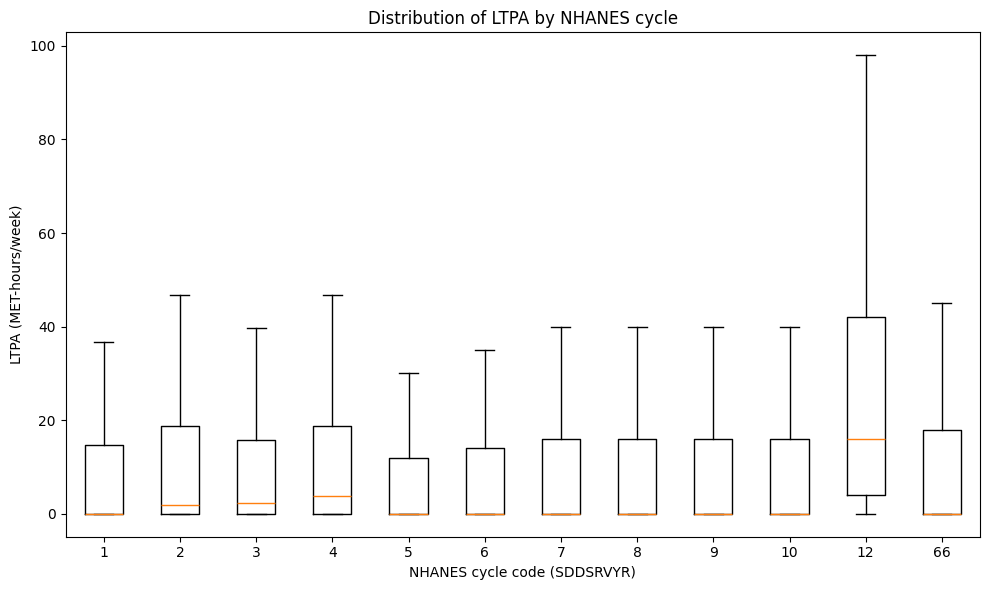

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# --- file path ---
PATH = Path("/Users/dengshuyue/Desktop/SDOH/analysis/data/cov/totalpa_9923_imputed.csv")

# --- load & prep ---
df = pd.read_csv(PATH)
year_col = next(c for c in df.columns if c.lower()=="sddsrvyr")
df[year_col] = pd.to_numeric(df[year_col], errors="coerce").astype("Int64")
df["ltpa"] = pd.to_numeric(df["ltpa"], errors="coerce")  # MET-hours/week
df = df.dropna(subset=["ltpa"])

# Which cycles to include (keep 66 as-is)
cycles = sorted(df[year_col].dropna().unique().tolist())

# --- summary table by cycle ---
def q(s, p): 
    try: return float(np.nanquantile(s, p))
    except: return np.nan

summ = (
    df[df[year_col].isin(cycles)]
      .groupby(year_col)
      .agg(
          n=("ltpa","size"),
          mean=("ltpa","mean"),
          median=("ltpa","median"),
          p10=("ltpa", lambda s: q(s, 0.10)),
          p25=("ltpa", lambda s: q(s, 0.25)),
          p75=("ltpa", lambda s: q(s, 0.75)),
          p90=("ltpa", lambda s: q(s, 0.90)),
          max=("ltpa","max")
      )
      .round(2)
      .reset_index()
      .rename(columns={year_col:"sddsrvyr"})
      .sort_values("sddsrvyr")
)
summ  # ← renders as a table in Jupyter

# --- nice-looking boxplot (cap outliers at 99th pct per cycle just for plotting) ---
plot_df = df.copy()
cap99 = plot_df.groupby(year_col)["ltpa"].quantile(0.99)
plot_df = plot_df.join(cap99.rename("cap99"), on=year_col)
plot_df["ltpa_capped"] = np.minimum(plot_df["ltpa"], plot_df["cap99"])

ordered = sorted(cycles)
data = [plot_df.loc[plot_df[year_col]==c, "ltpa_capped"].dropna().values for c in ordered]

plt.figure(figsize=(10,6))
plt.boxplot(data, labels=[str(int(c)) for c in ordered], showfliers=False)
plt.xlabel("NHANES cycle code (SDDSRVYR)")
plt.ylabel("LTPA (MET-hours/week)")
plt.title("Distribution of LTPA by NHANES cycle")
plt.tight_layout()
plt.show()

# --- optional: per-cycle histograms (one chart per cycle). Uncomment to use ---
# for c in ordered:
#     vals = plot_df.loc[plot_df[year_col]==c, "ltpa_capped"].dropna().values
#     if len(vals) == 0: 
#         continue
#     plt.figure(figsize=(7,4))
#     plt.hist(vals, bins=40)
#     plt.xlabel("LTPA (MET-hours/week)")
#     plt.ylabel("Count")
#     plt.title(f"LTPA distribution — cycle {int(c)}")
#     plt.tight_layout()
#     plt.show()


## Anthropometrics (BMX)

In [69]:
def build_bmx(cfg: Config = CONFIG) -> pd.DataFrame:
    """
    Load anthropometrics (BMX), tolerate csv/parquet and 99–18 vs 99–23 stacks,
    and compute BMI when BMXBMI is missing.
    Writes cov_bmx_1999_2023.parquet to cfg.out_dir.
    """
    ensure_dir(cfg.out_dir)

    def _read_any(p: Path) -> pd.DataFrame:
        return pd.read_parquet(p) if str(p).lower().endswith(".parquet") else pd.read_csv(p, low_memory=False)

    # 1) Choose a source
    if cfg.bmx_9923 and Path(cfg.bmx_9923).exists():
        src = Path(cfg.bmx_9923)
    else:
        src = pick_first_existing(
            cfg.interim_dir / "bmx_9923.parquet",
            cfg.interim_dir / "bmx_9923.csv",
            cfg.interim_dir / "bmx_9918.parquet",
            cfg.interim_dir / "bmx_9918.csv",
        )
    if src is None:
        raise FileNotFoundError(
            "BMX not found. Provide bmx_9923.parquet (preferred) or bmx_9918.parquet/csv under "
            f"{cfg.interim_dir}, or set CONFIG.bmx_9923 to a file."
        )

    # 2) Read + normalize
    bmx = upper_df(_read_any(src))
    for need in ["SEQN", "BMXWT", "BMXHT"]:
        if need not in bmx.columns:
            raise ValueError(f"BMX table missing required column: {need}")

    # helper: NaN series aligned to df
    def nan_series(df): 
        return pd.Series(np.nan, index=df.index, dtype="float")

    # 3) BMI: use BMXBMI if present, else compute weight(kg) / (height(m))^2
    bmi_src = pd.to_numeric(bmx["BMXBMI"], errors="coerce") if "BMXBMI" in bmx.columns else nan_series(bmx)
    wt = pd.to_numeric(bmx["BMXWT"], errors="coerce")
    ht_cm = pd.to_numeric(bmx["BMXHT"], errors="coerce")

    bmi = bmi_src.copy()
    missing = bmi.isna()
    if missing.any():
        bmi.loc[missing] = wt.loc[missing] / (ht_cm.loc[missing] / 100.0) ** 2

    out = pd.DataFrame(
        {
            "SEQN": bmx["SEQN"],
            "BMXWT": wt,
            "BMXHT": ht_cm,
            "BMI": pd.to_numeric(bmi, errors="coerce"),
        }
    )

    outp = cfg.out_dir / cfg.cov_bmx
    out.to_parquet(outp, index=False)
    log(f"✓ BMX → {outp} (source: {src.name})")
    return out


## Clinical & Conditions

In [17]:

@dataclass
class ClinicalThresholds:
    htn_sbp: float = 140.0
    htn_dbp: float = 90.0
    a1c_diabetes: float = 6.5
    fpg_diabetes: float = 126.0  # mg/dL

THR = ClinicalThresholds()

def build_clinical(cfg: Config = CONFIG, thr: ClinicalThresholds = THR) -> pd.DataFrame:
    ensure_dir(cfg.out_dir)

    clin_9923 = pick_first_existing(cfg.interim_dir / "clinical_9923.parquet", cfg.interim_dir / "clinical_9923.csv")
    if clin_9923:
        clin = read_any(clin_9923)
    else:
        p9918 = pick_first_existing(
            cfg.clinical_9918,
            cfg.interim_dir / "clinical_9918.parquet",
            cfg.interim_dir / "clinical_9918.csv",
            cfg.interim_dir / "nhanes_primary_anal_full_singleimputation_v2.parquet",
            cfg.interim_dir / "nhanes_primary_anal_full_singleimputation_v2.csv",
        )
        p1923 = pick_first_existing(cfg.clinical_1923, cfg.interim_dir / "clinical_1923.parquet", cfg.interim_dir / "clinical_1923.csv")
        if p9918 is None:
            raise FileNotFoundError("Provide clinical_9923 or clinical_9918 under interim.")
        clin = read_any(p9918)
        if p1923:
            clin = pd.concat([clin, read_any(p1923)], ignore_index=True)

    clin = upper_df(clin)

    # Derive BMI_CLAS if missing
    if "BMI_CLAS" not in clin.columns:
        bmi_src = None
        bmx_path = cfg.out_dir / cfg.cov_bmx
        if bmx_path.exists():
            bmx = upper_df(pd.read_parquet(bmx_path))
            if {"SEQN", "BMI"}.issubset(bmx.columns) and "SEQN" in clin.columns:
                bmi_src = clin["SEQN"].map(bmx.set_index("SEQN")["BMI"]).astype(float)
        if bmi_src is None:
            bmi_src = pd.to_numeric(clin.get("BMI", np.nan), errors="coerce")

        def bmi_class(x):
            if pd.isna(x):
                return pd.NA
            if x < 18.5:
                return "UNDER"
            if x < 25:
                return "NORMAL"
            if x < 30:
                return "OVER"
            return "OBESE"

        clin["BMI_CLAS"] = pd.Series([bmi_class(v) for v in bmi_src], dtype="string")

    # Derive HTN if missing
    if "HTN" not in clin.columns:
        sbp = pd.to_numeric(clin.get("SBP", np.nan), errors="coerce")
        dbp = pd.to_numeric(clin.get("DBP", np.nan), errors="coerce")
        diag_col = next((c for c in clin.columns if (("HTN" in c or "HYPERT" in c) and "MED" not in c and c != "HTN")), None)
        med_col = next((c for c in clin.columns if ("MED" in c and ("BP" in c or "HYPER" in c))), None)
        htn = pd.Series(0, index=clin.index, dtype="Int8")
        if diag_col:
            diag = pd.to_numeric(clin[diag_col], errors="coerce")
            htn = ((diag == 1) | (diag > 0)).astype("Int8")
        if med_col:
            med = pd.to_numeric(clin[med_col], errors="coerce")
            htn = ((htn == 1) | (med == 1) | (med > 0)).astype("Int8")
        htn = ((htn == 1) | (sbp >= thr.htn_sbp) | (dbp >= thr.htn_dbp)).astype("Int8")
        clin["HTN"] = htn

    # Derive HIGH_CHOL if missing
    if "HIGH_CHOL" not in clin.columns:
        tch = pd.to_numeric(clin.get("TCHOL", np.nan), errors="coerce")
        ldl = pd.to_numeric(clin.get("LDL", np.nan), errors="coerce")
        med_col = next((c for c in clin.columns if ("CHOL" in c and "MED" in c)), None)
        high = ((tch >= 240) | (ldl >= 160)).astype("Int8")
        if med_col:
            med = pd.to_numeric(clin[med_col], errors="coerce")
            high = ((high == 1) | (med == 1) | (med > 0)).astype("Int8")
        clin["HIGH_CHOL"] = high

    keep = ["SEQN", "BMI_CLAS", "DIABETES", "HTN", "HIGH_CHOL", "CVD", "CANCER", "SBP", "DBP", "TCHOL", "HDL", "LDL", "TG"]
    for k in keep:
        if k not in clin.columns:
            clin[k] = pd.Series(np.nan, index=clin.index)

    out = clin[keep].copy()
    for b in ["DIABETES", "HTN", "HIGH_CHOL", "CVD", "CANCER"]:
        out[b] = pd.to_numeric(out[b], errors="coerce").astype("Int8")

    outp = cfg.out_dir / cfg.cov_clinical
    out.to_parquet(outp, index=False)
    log(f"✓ CLN → {outp}")
    return out


## Household & Survey Core

In [115]:

SURVEY_KEEP = ["SEQN", "SDDSRVYR", "SDMVPSU", "SDMVSTRA", "WTMEC2YR"]

def build_household(cfg: Config = CONFIG) -> pd.DataFrame:
    ensure_dir(cfg.out_dir)
    demo = upper_df(pd.read_parquet(cfg.demo_9923))
    if "DMDHHSIZ" not in demo.columns:
        raise ValueError("DMDHHSIZ not found in DEMO stack.")
    out = demo[["SEQN", "DMDHHSIZ"]].copy()
    outp = cfg.out_dir / cfg.cov_household
    out.to_parquet(outp, index=False)
    log(f"✓ HH  → {outp}")
    return out

def get_survey_core(cfg: Config = CONFIG) -> pd.DataFrame:
    demo_p = None
    if cfg.demo_9923 and Path(cfg.demo_9923).exists():
        demo_p = cfg.demo_9923
    elif cfg.demo_9918 and Path(cfg.demo_9918).exists():
        demo_p = cfg.demo_9918
    else:
        demo_p = pick_first_existing(cfg.interim_dir / "demo_9923.parquet", cfg.interim_dir / "demo_9918.parquet")
    if demo_p is None:
        raise FileNotFoundError("Could not find DEMO table.")

    demo = upper_df(pd.read_parquet(demo_p))
    miss = [c for c in SURVEY_KEEP if c not in demo.columns]
    if miss:
        raise ValueError(f"Missing survey fields in DEMO: {miss}")
    return demo[SURVEY_KEEP].copy()


## Merge to Core

In [116]:

def build_core(cfg: Config = CONFIG) -> pd.DataFrame:
    ensure_dir(cfg.out_dir)

    smk = pd.read_parquet(cfg.out_dir / cfg.cov_smk)
    alc = pd.read_parquet(cfg.out_dir / cfg.cov_alc)
    pa = pd.read_parquet(cfg.out_dir / cfg.cov_pa)
    bmx = pd.read_parquet(cfg.out_dir / cfg.cov_bmx)
    clin = pd.read_parquet(cfg.out_dir / cfg.cov_clinical)
    hh = pd.read_parquet(cfg.out_dir / cfg.cov_household)
    survey = get_survey_core(cfg)

    core = survey
    for part in [smk, alc, pa, bmx, clin, hh]:
        core = core.merge(part, on="SEQN", how="left")

    core.columns = [c.upper() for c in core.columns]
    outp = cfg.out_dir / cfg.cov_core
    core.to_parquet(outp, index=False)
    log(f"✓ CORE → {outp}")
    return core


In [119]:
from pathlib import Path
import pandas as pd

def _upper_df(df: pd.DataFrame) -> pd.DataFrame:
    df.columns = [c.upper() for c in df.columns]
    return df

def _ensure_dir(p: Path | str):
    Path(p).mkdir(parents=True, exist_ok=True)

def _read_required(p: Path, label: str) -> pd.DataFrame:
    if not Path(p).exists():
        raise FileNotFoundError(f"Missing {label} file: {p}")
    df = pd.read_parquet(p)
    df = _upper_df(df)
    if "SEQN" not in df.columns:
        raise KeyError(f"{label} file lacks SEQN: {p}")
    return df

def build_core(cfg=CONFIG) -> pd.DataFrame:
    _ensure_dir(cfg.out_dir)

    # Default filenames if attributes are absent on cfg
    defaults = {
        "cov_smk":       "cov_smk.parquet",
        "cov_alc":       "cov_alc.parquet",
        "cov_pa":        "cov_pa.parquet",
        "cov_bmx":       "cov_bmx.parquet",
        "cov_clinical":  "cov_clinical.parquet",
        "cov_household": "cov_household.parquet",
        "cov_core":      "cov_core_1999_2023.parquet",
    }

    # Resolve paths
    def f(attr):  # filename resolver with default
        name = getattr(cfg, attr, defaults[attr])
        return Path(cfg.out_dir) / name

    # Load survey core (must include SEQN)
    survey = get_survey_core(cfg)
    survey = _upper_df(survey)
    if "SEQN" not in survey.columns:
        raise KeyError("SURVEY core (get_survey_core) lacks SEQN.")

    # Load parts with clear labels
    parts = [
        _read_required(f("cov_smk"),       "SMOKING"),
        _read_required(f("cov_alc"),       "ALCOHOL"),
        _read_required(f("cov_pa"),        "PHYSICAL ACTIVITY"),
        _read_required(f("cov_bmx"),       "BODY MEASURES"),
        _read_required(f("cov_clinical"),  "CLINICAL"),
        _read_required(f("cov_household"), "HOUSEHOLD"),
    ]

    # Merge
    core = survey
    for part in parts:
        core = core.merge(part, on="SEQN", how="left")

    core = _upper_df(core)
    outp = f("cov_core")
    core.to_parquet(outp, index=False)
    log(f"✓ CORE → {outp}")
    return core


## Orchestrator & Checks

In [120]:

def run_all(cfg: Config = CONFIG) -> Dict[str, pd.DataFrame]:
    ensure_dir(cfg.out_dir)
    out: Dict[str, pd.DataFrame] = {}
    out["smk"] = build_smk(cfg)
    out["alc"] = build_alc(cfg)
    out["pa"] = build_pa(cfg)
    out["bmx"] = build_bmx(cfg)
    out["clinical"] = build_clinical(cfg)
    out["household"] = build_household(cfg)
    out["core"] = build_core(cfg)
    return out

def quick_checks(cfg: Config = CONFIG) -> pd.Series:
    core = pd.read_parquet(cfg.out_dir / cfg.cov_core)
    checks = {
        "n_rows": int(len(core)),
        "n_unique_seqn": int(core["SEQN"].nunique()),
        "missing_bmi_pct": float(core["BMI"].isna().mean()),
        "missing_alcohol_cat_pct": float(core["ALCOHOL_CAT"].isna().mean()),
        "missing_smk_status_pct": float(core["SMK_STATUS"].isna().mean()),
        "has_weights": int("WTMEC2YR" in core.columns),
    }
    return pd.Series(checks)

def missingness_by_era(cfg: Config = CONFIG) -> pd.DataFrame:
    core = pd.read_parquet(cfg.out_dir / cfg.cov_core)
    era = np.where(core["SDDSRVYR"] <= 10, "1999–2018", "2019–2023")

    def miss(col: str) -> pd.Series:
        return core[col].isna().groupby(era).mean().mul(100).round(1)

    return pd.DataFrame({
        "SMK_STATUS %NA": miss("SMK_STATUS"),
        "LTPA_MET_HR_WK %NA": miss("LTPA_MET_HR_WK"),
        "BMI %NA": miss("BMI"),
        "WTMEC2YR %NA": miss("WTMEC2YR"),
    })


## Quick Start (run these)

In [127]:
from pathlib import Path

def _patch_all_cfg_attrs(cfg):
    """
    Ensure CONFIG has all attributes builders may probe, with safe defaults.
    Creates output/interim directories if needed.
    """
    # --- required dir attrs (with sensible defaults if missing) ---
    if not hasattr(cfg, "out_dir"):
        cfg.out_dir = Path("/Users/dengshuyue/Desktop/SDOH/analysis/output")
    if not hasattr(cfg, "interim_dir"):
        cfg.interim_dir = Path("/Users/dengshuyue/Desktop/SDOH/analysis/data/cov")

    # --- output filenames (always needed) ---
    out_defaults = {
        "cov_smk":       "cov_smk.parquet",
        "cov_alc":       "cov_alc.parquet",
        "cov_pa":        "cov_pa.parquet",
        "cov_bmx":       "cov_bmx.parquet",
        "cov_clinical":  "cov_clinical.parquet",
        "cov_household": "cov_household.parquet",
        "cov_core":      "cov_core_1999_2023.parquet",
    }
    for k, v in out_defaults.items():
        if not hasattr(cfg, k):
            setattr(cfg, k, v)

    # --- optional source paths; builders *may* look for these first ---
    bases    = ["smk", "alq_stack", "pa", "bmx", "clinical", "household", "demo"]
    suffixes = ["9918", "1923", "9923"]   # cover all variants used in code
    for b in bases:
        for s in suffixes:
            attr = f"{b}_{s}"
            if not hasattr(cfg, attr):
                setattr(cfg, attr, None)

    # ensure dirs exist
    Path(cfg.out_dir).mkdir(parents=True, exist_ok=True)
    Path(cfg.interim_dir).mkdir(parents=True, exist_ok=True)
    return cfg  # handy if you want to assign/inspect

# ---- RUN THIS ONCE BEFORE run_all() ----
_patch_all_cfg_attrs(CONFIG)


In [128]:
print("cov_alc:", getattr(CONFIG, "cov_alc", "<missing>"))
print("clinical_1923 exists?", hasattr(CONFIG, "clinical_1923"))


cov_alc: cov_alc.parquet
clinical_1923 exists? True


In [130]:
from pathlib import Path

alc_name = getattr(CONFIG, "cov_alc", "cov_alc.parquet")
(Path(CONFIG.out_dir) / alc_name).unlink(missing_ok=True)


CONFIG.demo_9923 = Path("/Users/dengshuyue/Desktop/SDOH/analysis/data/cov/demo9923.parquet")
assert CONFIG.demo_9923.exists(), "demo9923.parquet not found at the path above"

run_all()


✓ SMK → /Users/dengshuyue/Desktop/SDOH/analysis/output/cov_smk.parquet (using smk_9918.csv); missing: {'SMK_STATUS': 0.001, 'CIGS_PER_DAY': 0.794, 'PACK_YEARS': 0.78}
✓ ALC → /Users/dengshuyue/Desktop/SDOH/analysis/output/cov_alc.parquet
✓ Loaded existing totalpa_9923_imputed from /Users/dengshuyue/Desktop/SDOH/analysis/data/cov/totalpa_9923_imputed.parquet
✓ PA  → /Users/dengshuyue/Desktop/SDOH/analysis/output/cov_pa.parquet
✓ BMX → /Users/dengshuyue/Desktop/SDOH/analysis/output/cov_bmx.parquet (source: bmx_9918.csv)
✓ CLN → /Users/dengshuyue/Desktop/SDOH/analysis/output/cov_clinical.parquet
✓ HH  → /Users/dengshuyue/Desktop/SDOH/analysis/output/cov_household.parquet
✓ CORE → /Users/dengshuyue/Desktop/SDOH/analysis/output/cov_core_1999_2023.parquet


{'smk':            SEQN SMK_STATUS  CIGS_PER_DAY  PACK_YEARS  FORMER_SMOKER
 0           2.0      NEVER           NaN         NaN              0
 1           5.0     FORMER           NaN         NaN              1
 2           7.0     FORMER           NaN   8030.0000              1
 3          10.0    CURRENT           1.0         NaN              0
 4          12.0      NEVER           NaN         NaN              0
 ...         ...        ...           ...         ...            ...
 55076  102950.0     FORMER           NaN   6198.0000              1
 55077  102952.0      NEVER           NaN         NaN              0
 55078  102953.0     FORMER           NaN    387.8125              1
 55079  102954.0      NEVER           NaN         NaN              0
 55080  102956.0    CURRENT           2.0         NaN              0
 
 [55081 rows x 5 columns],
 'alc':            SEQN  DRINKS_PER_DAY ALCOHOL_CAT
 0           2.0        0.789041    MODERATE
 1           5.0       12.000000       

In [133]:
from pathlib import Path
import pandas as pd

OUT = Path("/Users/dengshuyue/Desktop/SDOH/analysis/output")
p = OUT / "cov_core_1999_2023.parquet"

core = pd.read_parquet(p)

print("shape:", core.shape)
print("first 20 columns:", core.columns.tolist()[:20])

# peek rows
core.head(10)


shape: (128809, 64)
first 20 columns: ['SEQN', 'SDDSRVYR_X', 'SDMVPSU_X', 'SDMVSTRA_X', 'WTMEC2YR', 'SMK_STATUS', 'CIGS_PER_DAY', 'PACK_YEARS', 'FORMER_SMOKER', 'DRINKS_PER_DAY', 'ALCOHOL_CAT', 'SDDSRVYR_Y', 'LTPA', 'SDMVPSU_Y', 'SDMVSTRA_Y', 'AGE', 'SEX', 'RE', 'EDU', 'PIR']


,SEQN,SDDSRVYR_X,SDMVPSU_X,SDMVSTRA_X,WTMEC2YR,SMK_STATUS,CIGS_PER_DAY,PACK_YEARS,FORMER_SMOKER,DRINKS_PER_DAY,ALCOHOL_CAT,SDDSRVYR_Y,LTPA,SDMVPSU_Y,SDMVSTRA_Y,AGE,SEX,RE,EDU,PIR,TCHOL_X,HDL_X,LDL_X,TG_X,WC,BMI_X,DM_SELF,HBA1C,FPG,CHF,CHD,MI,STROKE,CANCER_X,EMPHYSEMA,BRONCHITIS,ASTHMA,RE2,COPD,SBP_X,DBP_X,DM_RX,CHOL_RX,ANGINA_RX,HTN_RX,ROSEQ,METSCORE,IMP,BMXWT,BMXHT,BMI_Y,BMI_CLAS,DIABETES,HTN,HIGH_CHOL,CVD,CANCER_Y,SBP_Y,DBP_Y,TCHOL_Y,HDL_Y,LDL_Y,TG_Y,DMDHHSIZ
0,1.0,1.0,1.0,5.0,10982.898896,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,5.0,None,None,None,None,NaN,None,None,None,None,NaN,NaN,None,NaN,NaN,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None,None,None,None,None,NaN,1.0,12.5,91.6,14.897695,UNDER,0,0,0,0,0,91.333333,56.000000,131.0,59.0,54.0,99.0,3.0
1,2.0,1.0,3.0,1.0,28325.384898,NEVER,NaN,NaN,0.0,0.789041,MODERATE,1.0,NaN,3.0,1.0,None,None,None,None,NaN,None,None,None,None,NaN,NaN,None,NaN,NaN,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None,None,None,None,None,NaN,1.0,75.4,174.0,24.904215,NORMAL,0,0,0,0,1,100.666667,56.666667,215.0,54.0,136.0,128.0,1.0
2,3.0,1.0,2.0,7.0,46192.256945,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2.0,7.0,None,None,None,None,NaN,None,None,None,None,NaN,NaN,None,NaN,NaN,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None,None,None,None,None,NaN,1.0,32.9,136.6,17.631713,UNDER,0,0,0,0,0,108.666667,62.000000,129.0,30.0,58.0,202.0,4.0
3,4.0,1.0,1.0,2.0,10251.260020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,NaN,None,None,None,None,NaN,NaN,None,NaN,NaN,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None,None,None,None,None,NaN,NaN,13.3,NaN,NaN,<NA>,0,0,1,0,0,95.333333,61.333333,211.0,43.0,161.0,37.0,7.0
4,5.0,1.0,2.0,8.0,99445.065735,FORMER,NaN,NaN,1.0,12.000000,HEAVY,1.0,NaN,2.0,8.0,None,None,None,None,NaN,None,None,None,None,NaN,NaN,None,NaN,NaN,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None,None,None,None,None,NaN,1.0,92.5,178.3,29.096386,OVER,0,1,1,0,0,122.000000,82.666667,279.0,42.0,168.0,347.0,3.0
5,6.0,1.0,2.0,2.0,39656.600444,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2.0,2.0,None,None,None,None,NaN,None,None,None,None,NaN,NaN,None,NaN,NaN,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None,None,None,None,None,NaN,1.0,59.2,162.0,22.557537,NORMAL,0,0,0,0,0,114.666667,68.000000,153.0,61.0,59.0,181.0,2.0
6,7.0,1.0,2.0,4.0,25525.423409,FORMER,NaN,8030.0,1.0,NaN,NONE,1.0,NaN,2.0,4.0,None,None,None,None,NaN,None,None,None,None,NaN,NaN,None,NaN,NaN,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None,None,None,None,None,NaN,1.0,78.0,162.9,29.393577,OVER,0,0,1,0,0,125.333333,80.000000,245.0,105.0,127.0,62.0,1.0
7,8.0,1.0,1.0,6.0,31510.587866,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,6.0,None,None,None,None,NaN,None,None,None,None,NaN,NaN,None,NaN,NaN,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None,None,None,None,None,NaN,1.0,40.7,162.0,15.508307,UNDER,0,0,0,0,0,100.666667,49.333333,162.0,67.0,88.0,33.0,7.0
8,9.0,1.0,2.0,9.0,7575.870247,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2.0,9.0,None,None,None,None,NaN,None,None,None,None,NaN,NaN,None,NaN,NaN,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None,None,None,None,None,NaN,1.0,45.5,156.9,18.482704,UNDER,0,0,0,0,0,109.333333,53.333333,148.0,58.0,79.0,56.0,4.0
9,10.0,1.0,1.0,7.0,22445.808572,CURRENT,1.0,NaN,0.0,0.197260,MODERATE,1.0,NaN,1.0,7.0,None,None,None,None,NaN,None,None,None,None,NaN,NaN,None,NaN,NaN,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None,None,None,None,None,NaN,1.0,111.8,190.1,30.936955,OBESE,0,1,0,0,0,145.333333,96.000000,140.0,51.0,80.0,45.0,1.0


In [135]:
import re

def coalesce_xy(df):
    pairs = {}
    for c in df.columns:
        m = re.match(r'(.+)_([xy])$', c, flags=re.IGNORECASE)
        if m:
            base, side = m.group(1), m.group(2).upper()
            pairs.setdefault(base, {})[side] = c

    for base, d in pairs.items():
        cx, cy = d.get("X"), d.get("Y")
        if cx and cy:
            df[base] = df[cx].combine_first(df[cy])
            df.drop(columns=[cx, cy], inplace=True)
        elif cx:
            df.rename(columns={cx: base}, inplace=True)
        elif cy:
            df.rename(columns={cy: base}, inplace=True)
    return df

core = coalesce_xy(core)


/var/folders/nx/82zd518d5gb2gsf5fhydbkj00000gn/T/ipykernel_77481/1034675029.py:14: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df[base] = df[cx].combine_first(df[cy])
/var/folders/nx/82zd518d5gb2gsf5fhydbkj00000gn/T/ipykernel_77481/1034675029.py:14: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df[base] = df[cx].combine_first(df[cy])
/var/folders/nx/82zd518d5gb2gsf5fhydbkj00000gn/T/ipykernel_77481/1034675029.py:14: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty

In [136]:
core.shape, core.columns[:30]

((128809, 53),
 Index(['SEQN', 'WTMEC2YR', 'SMK_STATUS', 'CIGS_PER_DAY', 'PACK_YEARS', 'FORMER_SMOKER', 'DRINKS_PER_DAY', 'ALCOHOL_CAT', 'LTPA', 'AGE', 'SEX', 'RE', 'EDU', 'PIR', 'WC', 'DM_SELF', 'HBA1C', 'FPG',
        'CHF', 'CHD', 'MI', 'STROKE', 'EMPHYSEMA', 'BRONCHITIS', 'ASTHMA', 'RE2', 'COPD', 'DM_RX', 'CHOL_RX', 'ANGINA_RX'],
       dtype='object'))

In [137]:
core.head(10)

,SEQN,WTMEC2YR,SMK_STATUS,CIGS_PER_DAY,PACK_YEARS,FORMER_SMOKER,DRINKS_PER_DAY,ALCOHOL_CAT,LTPA,AGE,SEX,RE,EDU,PIR,WC,DM_SELF,HBA1C,FPG,CHF,CHD,MI,STROKE,EMPHYSEMA,BRONCHITIS,ASTHMA,RE2,COPD,DM_RX,CHOL_RX,ANGINA_RX,HTN_RX,ROSEQ,METSCORE,IMP,BMXWT,BMXHT,BMI_CLAS,DIABETES,HTN,HIGH_CHOL,CVD,DMDHHSIZ,SDDSRVYR,SDMVPSU,SDMVSTRA,TCHOL,HDL,LDL,TG,BMI,CANCER,SBP,DBP
0,1.0,10982.898896,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,NaN,NaN,None,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,1.0,12.5,91.6,UNDER,0,0,0,0,3.0,1.0,1.0,5.0,131.0,59.0,54.0,99.0,14.897695,0,91.333333,56.000000
1,2.0,28325.384898,NEVER,NaN,NaN,0.0,0.789041,MODERATE,NaN,None,None,None,None,NaN,NaN,None,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,1.0,75.4,174.0,NORMAL,0,0,0,0,1.0,1.0,3.0,1.0,215.0,54.0,136.0,128.0,24.904215,1,100.666667,56.666667
2,3.0,46192.256945,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,NaN,NaN,None,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,1.0,32.9,136.6,UNDER,0,0,0,0,4.0,1.0,2.0,7.0,129.0,30.0,58.0,202.0,17.631713,0,108.666667,62.000000
3,4.0,10251.260020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,NaN,NaN,None,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,13.3,NaN,<NA>,0,0,1,0,7.0,1.0,1.0,2.0,211.0,43.0,161.0,37.0,NaN,0,95.333333,61.333333
4,5.0,99445.065735,FORMER,NaN,NaN,1.0,12.000000,HEAVY,NaN,None,None,None,None,NaN,NaN,None,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,1.0,92.5,178.3,OVER,0,1,1,0,3.0,1.0,2.0,8.0,279.0,42.0,168.0,347.0,29.096386,0,122.000000,82.666667
5,6.0,39656.600444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,NaN,NaN,None,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,1.0,59.2,162.0,NORMAL,0,0,0,0,2.0,1.0,2.0,2.0,153.0,61.0,59.0,181.0,22.557537,0,114.666667,68.000000
6,7.0,25525.423409,FORMER,NaN,8030.0,1.0,NaN,NONE,NaN,None,None,None,None,NaN,NaN,None,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,1.0,78.0,162.9,OVER,0,0,1,0,1.0,1.0,2.0,4.0,245.0,105.0,127.0,62.0,29.393577,0,125.333333,80.000000
7,8.0,31510.587866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,NaN,NaN,None,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,1.0,40.7,162.0,UNDER,0,0,0,0,7.0,1.0,1.0,6.0,162.0,67.0,88.0,33.0,15.508307,0,100.666667,49.333333
8,9.0,7575.870247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,NaN,NaN,None,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,1.0,45.5,156.9,UNDER,0,0,0,0,4.0,1.0,2.0,9.0,148.0,58.0,79.0,56.0,18.482704,0,109.333333,53.333333
9,10.0,22445.808572,CURRENT,1.0,NaN,0.0,0.197260,MODERATE,NaN,None,None,None,None,NaN,NaN,None,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,1.0,111.8,190.1,OBESE,0,1,0,0,1.0,1.0,1.0,7.0,140.0,51.0,80.0,45.0,30.936955,0,145.333333,96.000000


In [53]:
# Only (re)build smoking
smk = build_smk(CONFIG)          # writes cov_smk_1999_2023.parquet
smk.head()


✓ SMK → /Users/dengshuyue/Desktop/SDOH/analysis/output/cov_smk_1999_2023.parquet (using smk_9918.csv); missing: {'SMK_STATUS': 0.001, 'CIGS_PER_DAY': 0.794, 'PACK_YEARS': 0.78}


,SEQN,SMK_STATUS,CIGS_PER_DAY,PACK_YEARS,FORMER_SMOKER
0,2.0,NEVER,NaN,NaN,0
1,5.0,FORMER,NaN,NaN,1
2,7.0,FORMER,NaN,8030.0,1
3,10.0,CURRENT,1.0,NaN,0
4,12.0,NEVER,NaN,NaN,0


<h2> Merge Mortality </h2>

In [59]:
from pathlib import Path
import pandas as pd

BASE = Path("/Users/dengshuyue/Desktop/SDOH/analysis")
DATA = BASE / "data" / "cov"
OUT  = BASE / "output"

# 1) Load
core = pd.read_parquet(OUT / "cov_core_1999_2023.parquet")
mort_with_demo = pd.read_parquet(OUT / "mort_with_demo.parquet")  # built earlier
demo_age = pd.read_parquet(DATA / "demo9923.parquet")[["SEQN", "RIDAGEYR"]].drop_duplicates("SEQN")

# 2) Merge mortality fields you need
need_from_mort = ["SEQN", "TIME_Y", "EVENT"]
missing = [c for c in need_from_mort if c not in mort_with_demo.columns]
if missing:
    raise ValueError(f"mort_with_demo is missing columns: {missing}")

core_mort = core.merge(mort_with_demo[need_from_mort], on="SEQN", how="inner")

# 3) Add age (RIDAGEYR) from DEMO
core_mort = core_mort.merge(demo_age, on="SEQN", how="left")

# 4) Keep mortality-linked cycles using SDDSRVYR from *core*
core_mort_9918 = core_mort[core_mort["SDDSRVYR"].between(1, 10)].copy()

# 5) Save
out_path = OUT / "core_mort_1999_2018.parquet"
core_mort_9918.to_parquet(out_path, index=False)

print("Saved:", out_path, core_mort_9918.shape)
print("Age non-missing:", core_mort_9918["RIDAGEYR"].notna().mean().round(3))
print("Events (%):", round(100 * core_mort_9918["EVENT"].mean(), 2))
print("TIME_Y median (y):", core_mort_9918["TIME_Y"].median())


Saved: /Users/dengshuyue/Desktop/SDOH/analysis/output/core_mort_1999_2018.parquet (59064, 32)
Age non-missing: 1.0
Events (%): 15.66
TIME_Y median (y): 9.416666666666666


In [60]:
core_mort_9918.head(10)

,SEQN,SDDSRVYR,SDMVPSU,SDMVSTRA,WTMEC2YR,SMK_STATUS,CIGS_PER_DAY,PACK_YEARS,FORMER_SMOKER,DRINKS_PER_DAY,ALCOHOL_CAT,LTPA_MET_HR_WK,LTPA_IMPUTED_FLAG,BMXWT,BMXHT,BMI,BMI_CLAS,DIABETES,HTN,HIGH_CHOL,CVD,CANCER,SBP,DBP,TCHOL,HDL,LDL,TG,DMDHHSIZ,TIME_Y,EVENT,RIDAGEYR
0,2.0,1.0,3.0,1.0,28325.384898,NEVER,NaN,NaN,0.0,0.789041,MODERATE,NaN,0.0,75.4,174.0,24.904215,NORMAL,0,0,0,0,1,100.666667,56.666667,215.0,54.0,136.0,128.0,1.0,14.750000,1,77.0
1,5.0,1.0,2.0,8.0,99445.065735,FORMER,NaN,NaN,1.0,12.000000,HEAVY,NaN,0.0,92.5,178.3,29.096386,OVER,0,1,1,0,0,122.000000,82.666667,279.0,42.0,168.0,347.0,3.0,20.333333,0,49.0
2,6.0,1.0,2.0,2.0,39656.600444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.2,162.0,22.557537,NORMAL,0,0,0,0,0,114.666667,68.000000,153.0,61.0,59.0,181.0,2.0,20.416667,0,19.0
3,7.0,1.0,2.0,4.0,25525.423409,FORMER,NaN,8030.0,1.0,NaN,NONE,NaN,0.0,78.0,162.9,29.393577,OVER,0,0,1,0,0,125.333333,80.000000,245.0,105.0,127.0,62.0,1.0,19.666667,0,59.0
4,10.0,1.0,1.0,7.0,22445.808572,CURRENT,1.0,NaN,0.0,0.197260,MODERATE,NaN,0.0,111.8,190.1,30.936955,OBESE,0,1,0,0,0,145.333333,96.000000,140.0,51.0,80.0,45.0,1.0,19.250000,1,43.0
5,12.0,1.0,2.0,6.0,95494.214052,NEVER,NaN,NaN,0.0,0.857129,MODERATE,NaN,0.0,99.2,180.0,30.617284,OBESE,0,1,0,0,0,176.666667,102.000000,156.0,38.0,89.0,146.0,4.0,19.666667,0,37.0
6,13.0,1.0,2.0,13.0,1843.950828,FORMER,NaN,1095.0,1.0,2.000000,HEAVY,NaN,0.0,63.6,157.7,25.573710,OVER,1,1,1,0,0,133.333333,70.000000,314.0,49.0,260.0,16.0,2.0,1.333333,1,70.0
7,14.0,1.0,1.0,12.0,19486.733790,CURRENT,1.0,NaN,0.0,1.000000,MODERATE,NaN,0.0,75.5,166.2,27.332850,OVER,0,0,0,0,0,138.000000,59.333333,174.0,40.0,123.0,49.0,1.0,11.333333,1,81.0
8,15.0,1.0,2.0,11.0,114519.177908,CURRENT,2.0,NaN,0.0,8.000000,HEAVY,NaN,0.0,81.6,174.9,26.675375,OVER,0,0,0,0,0,108.000000,68.666667,199.0,58.0,131.0,54.0,2.0,19.250000,0,38.0
9,16.0,1.0,1.0,11.0,12565.995924,NEVER,NaN,NaN,0.0,NaN,NONE,NaN,0.0,41.5,144.2,19.958026,NORMAL,0,1,0,0,0,147.333333,60.666667,164.0,55.0,73.0,187.0,1.0,5.166667,1,85.0


In [62]:
core_mort_9918["RIDAGEYR"].describe()
core_mort_9918["RIDAGEYR"].isna().mean().round(3)  # missing rate
core_mort_9918.query("RIDAGEYR < 0 or RIDAGEYR > 120").shape  # out-of-range?


(0, 32)

In [63]:
core_mort_9918["RIDAGEYR"].describe()

count    59064.000000
mean        47.734119
std         19.504749
min         18.000000
25%         31.000000
50%         47.000000
75%         64.000000
max         85.000000
Name: RIDAGEYR, dtype: float64

In [114]:
core_mort_9918.head(10)

,SEQN,SDDSRVYR,SDMVPSU,SDMVSTRA,WTMEC2YR,SMK_STATUS,CIGS_PER_DAY,PACK_YEARS,FORMER_SMOKER,DRINKS_PER_DAY,ALCOHOL_CAT,LTPA_MET_HR_WK,LTPA_IMPUTED_FLAG,BMXWT,BMXHT,BMI,BMI_CLAS,DIABETES,HTN,HIGH_CHOL,CVD,CANCER,SBP,DBP,TCHOL,HDL,LDL,TG,DMDHHSIZ,TIME_Y,EVENT,RIDAGEYR
0,2.0,1.0,3.0,1.0,28325.384898,NEVER,NaN,NaN,0.0,0.789041,MODERATE,NaN,0.0,75.4,174.0,24.904215,NORMAL,0,0,0,0,1,100.666667,56.666667,215.0,54.0,136.0,128.0,1.0,14.750000,1,77.0
1,5.0,1.0,2.0,8.0,99445.065735,FORMER,NaN,NaN,1.0,12.000000,HEAVY,NaN,0.0,92.5,178.3,29.096386,OVER,0,1,1,0,0,122.000000,82.666667,279.0,42.0,168.0,347.0,3.0,20.333333,0,49.0
2,6.0,1.0,2.0,2.0,39656.600444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.2,162.0,22.557537,NORMAL,0,0,0,0,0,114.666667,68.000000,153.0,61.0,59.0,181.0,2.0,20.416667,0,19.0
3,7.0,1.0,2.0,4.0,25525.423409,FORMER,NaN,8030.0,1.0,NaN,NONE,NaN,0.0,78.0,162.9,29.393577,OVER,0,0,1,0,0,125.333333,80.000000,245.0,105.0,127.0,62.0,1.0,19.666667,0,59.0
4,10.0,1.0,1.0,7.0,22445.808572,CURRENT,1.0,NaN,0.0,0.197260,MODERATE,NaN,0.0,111.8,190.1,30.936955,OBESE,0,1,0,0,0,145.333333,96.000000,140.0,51.0,80.0,45.0,1.0,19.250000,1,43.0
5,12.0,1.0,2.0,6.0,95494.214052,NEVER,NaN,NaN,0.0,0.857129,MODERATE,NaN,0.0,99.2,180.0,30.617284,OBESE,0,1,0,0,0,176.666667,102.000000,156.0,38.0,89.0,146.0,4.0,19.666667,0,37.0
6,13.0,1.0,2.0,13.0,1843.950828,FORMER,NaN,1095.0,1.0,2.000000,HEAVY,NaN,0.0,63.6,157.7,25.573710,OVER,1,1,1,0,0,133.333333,70.000000,314.0,49.0,260.0,16.0,2.0,1.333333,1,70.0
7,14.0,1.0,1.0,12.0,19486.733790,CURRENT,1.0,NaN,0.0,1.000000,MODERATE,NaN,0.0,75.5,166.2,27.332850,OVER,0,0,0,0,0,138.000000,59.333333,174.0,40.0,123.0,49.0,1.0,11.333333,1,81.0
8,15.0,1.0,2.0,11.0,114519.177908,CURRENT,2.0,NaN,0.0,8.000000,HEAVY,NaN,0.0,81.6,174.9,26.675375,OVER,0,0,0,0,0,108.000000,68.666667,199.0,58.0,131.0,54.0,2.0,19.250000,0,38.0
9,16.0,1.0,1.0,11.0,12565.995924,NEVER,NaN,NaN,0.0,NaN,NONE,NaN,0.0,41.5,144.2,19.958026,NORMAL,0,1,0,0,0,147.333333,60.666667,164.0,55.0,73.0,187.0,1.0,5.166667,1,85.0


<h2>Sanity Checks </h2>

In [22]:
# Sanity checks
quick_checks()

n_rows                     128809.000000
n_unique_seqn              128809.000000
missing_bmi_pct                 0.318378
missing_alcohol_cat_pct         0.465402
missing_smk_status_pct          0.572903
has_weights                     1.000000
dtype: float64

In [23]:
# Missingness by era table
missingness_by_era()

,SMK_STATUS %NA,LTPA_MET_HR_WK %NA,BMI %NA,WTMEC2YR %NA
1999–2018,45.7,100.0,13.3,0.0
2019–2023,100.0,100.0,100.0,56.6


In [35]:
# 1) Basic peek
core = pd.read_parquet(CONFIG.out_dir / CONFIG.cov_core)
core.head(3)

# 2) Unique participants and NA overview
core["SEQN"].nunique(), core.isna().mean().round(3).sort_values().head(10)

# 3) Alcohol category distribution
core["ALCOHOL_CAT"].value_counts(dropna=False)

# 4) Smoking status distribution
core["SMK_STATUS"].value_counts(dropna=False)

# 5) Survey design fields present?
set(["SDDSRVYR","SDMVPSU","SDMVSTRA","WTMEC2YR"]).issubset(core.columns)

# 6) BMI sanity (no negatives and in a plausible range)
core["BMI"].describe()
((core["BMI"] >= 10) & (core["BMI"] <= 80)).mean()


np.float64(0.6815517549239571)

In [38]:
# 3) Alcohol category distribution
core["ALCOHOL_CAT"].value_counts(dropna=False)

ALCOHOL_CAT
NaN         59948
NONE        42792
MODERATE    14843
HEAVY       11226
Name: count, dtype: int64

In [113]:
# Distribution checks
core["ALCOHOL_CAT"].value_counts(dropna=False, normalize=True).round(3)
core["SMK_STATUS"].value_counts(dropna=False, normalize=True).round(3)


SMK_STATUS
NaN        0.573
NEVER      0.233
FORMER     0.106
CURRENT    0.089
Name: proportion, dtype: float64